# 15. 계층적 모형

In [2]:
library(bayesrules)
library(tidyverse)
library(rstanarm)
library(broom.mixed)

In [4]:
data(cherry_blossom_sample)

running <- cherry_blossom_sample %>% 
  select(runner, age, net)

<br>

#### 각 참가자들의 매 대회의 연령별 기록 시간

In [6]:
running %>% head

runner,age,net
<fct>,<int>,<dbl>
1,53,83.98333
1,54,74.30000
1,55,75.15000
1,56,74.21667
1,57,74.25000
1,58,NA


Warning message:
"Removed 67 rows containing non-finite values (`stat_boxplot()`)."


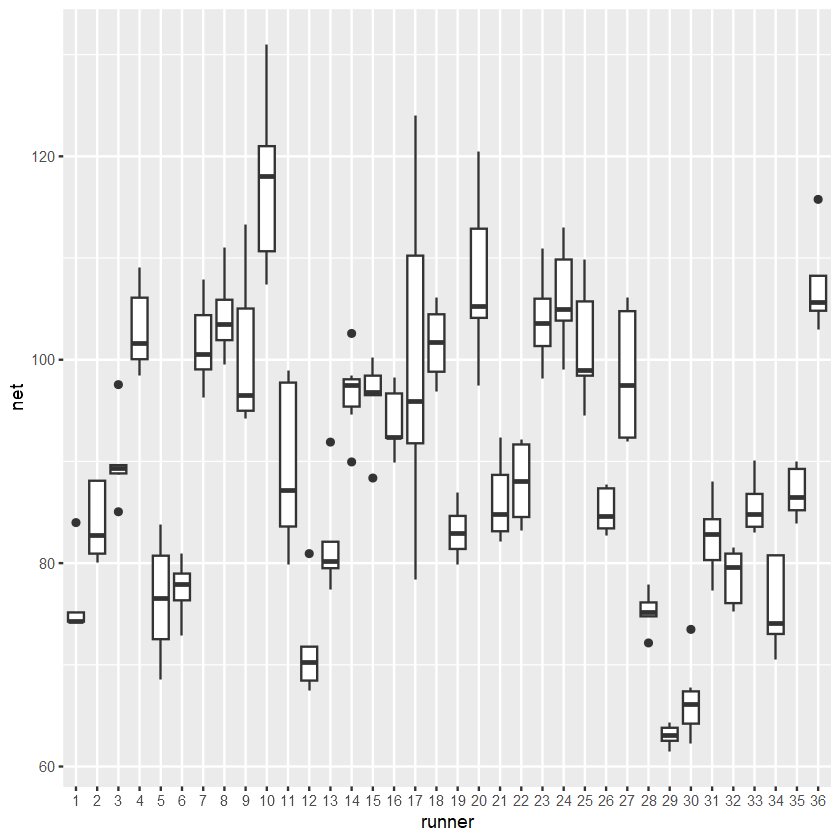

In [7]:
ggplot(running, aes(x = runner, y = net)) + 
  geom_boxplot()

<br>

## 15.01. 완전풀링
<br>

#### 완전풀링 분석 : 모든 관측값을 하나의 풀 (모집단)으로 가정하여, 하나의 모형을 구축

#### 완전풀링은 본래 아래와 같은 가정을 가짐
1. 각 관측값은 다른 관측값과 독립
2. 변수들 간의 관계는 일반화 될 수 있음

<br>

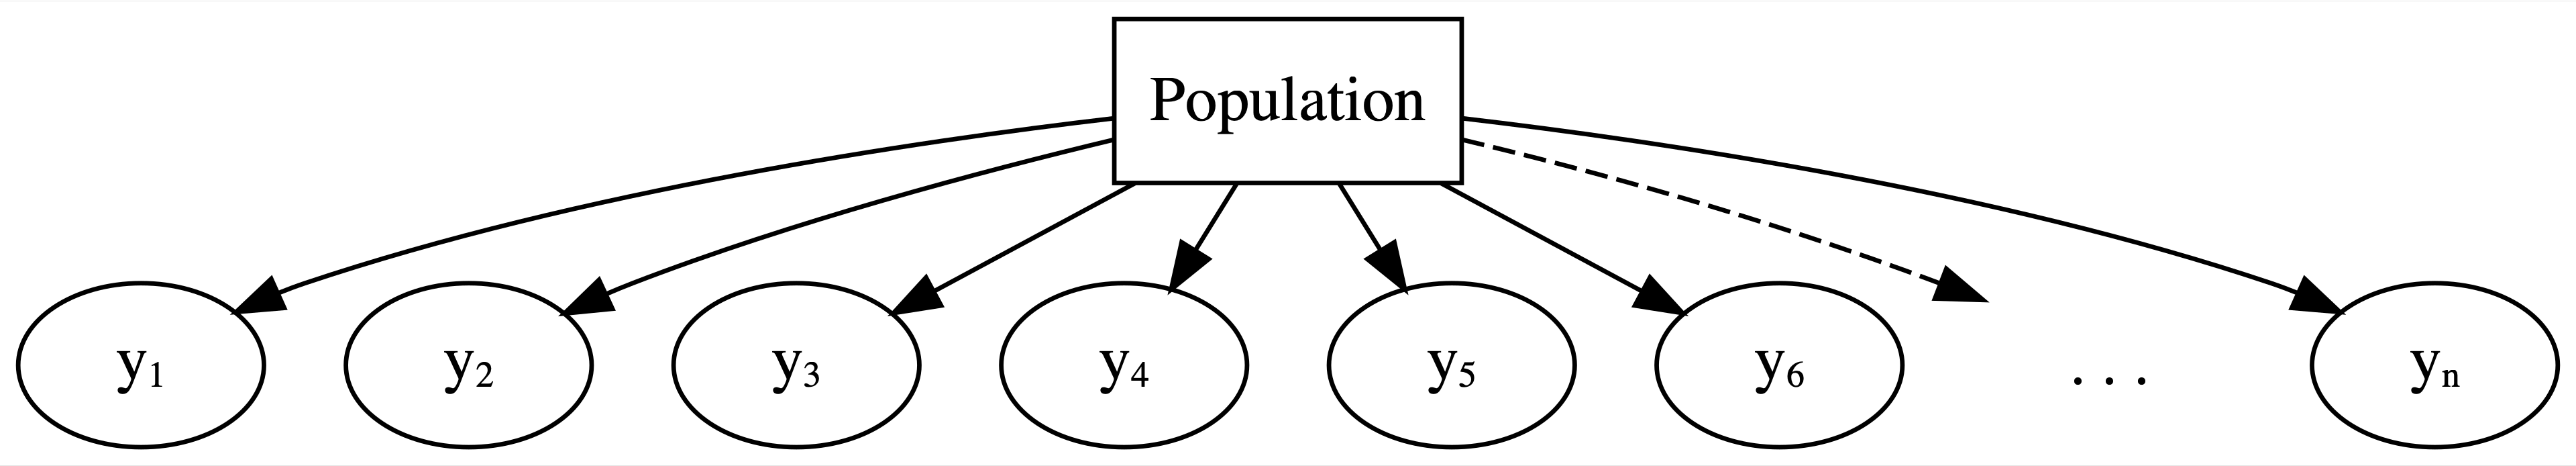

<br>


<br>

<hr>

#### 예)
#### 연령이 증가함에 따라 기록 시간에 대해서 명확한 추세가 없으며, 변동이 큼

Warning message:
"Removed 67 rows containing missing values (`geom_point()`)."


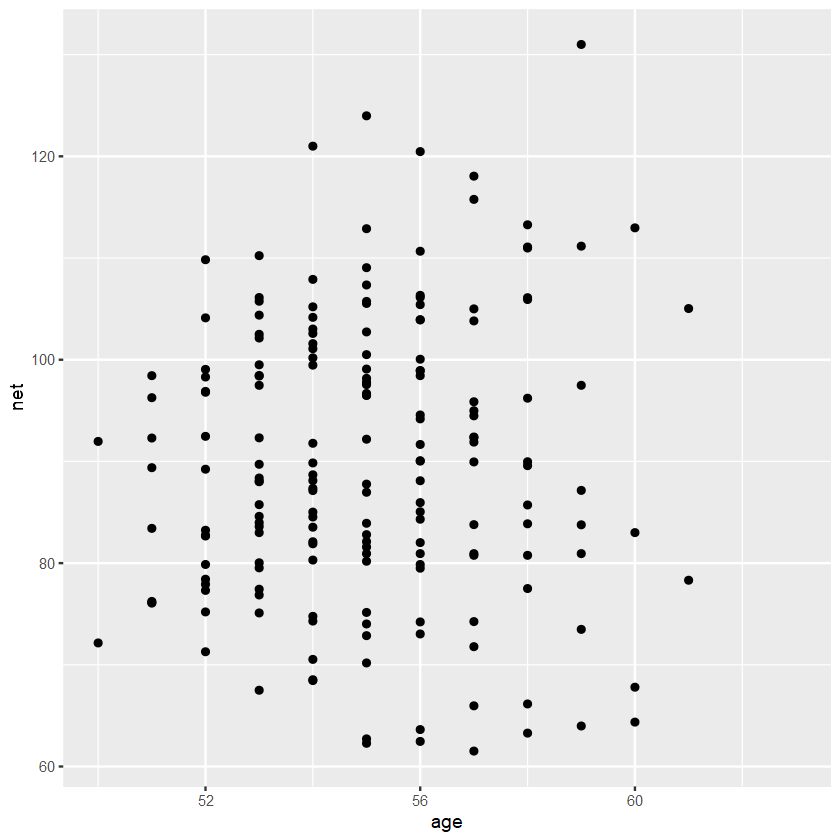

In [8]:
ggplot(running, aes(y = net, x = age)) + 
  geom_point()

<br>

#### 정규회귀모형 적용
$$\begin{equation}
Y_i | \beta_0, \beta_1, \sigma \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i  .
\end{equation}$$

In [ ]:
complete_pooled_model <- stan_glm(
  net ~ age, 
  data = running, family = gaussian, 
  prior_intercept = normal(0, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

In [11]:
prior_summary(complete_pooled_model)

Priors for model 'complete_pooled_model' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 35)

Coefficients
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 15)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.072)
------
See help('prior_summary.stanreg') for more details

<br>

#### 각 매개변수별 사후분포의 통계량

In [10]:
tidy(complete_pooled_model, conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),75.1999496,24.6161022,43.6805427,106.4566330
age,0.2679488,0.4461854,-0.3017243,0.8417984


#### 각 매개변수별 사후분포의 중앙값 (추정치)를 통한 사후예측선

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 67 rows containing non-finite values (`stat_smooth()`)."


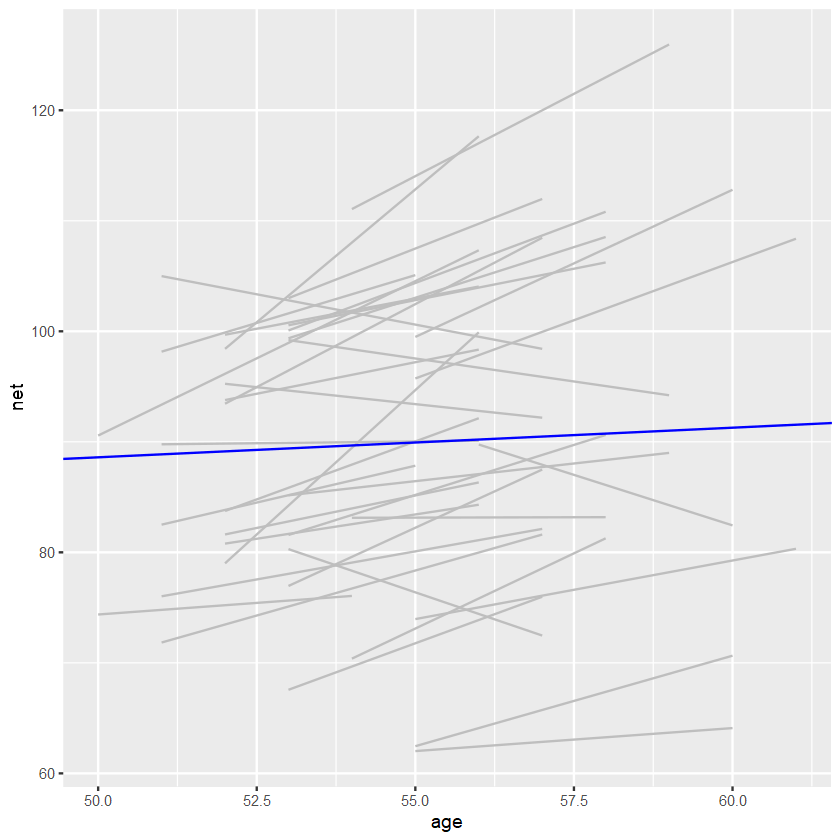

In [12]:
ggplot(running, aes(x = age, y = net, group = runner)) + 
  geom_smooth(method = "lm", se = FALSE, color = "gray", size = 0.5) + 
  geom_abline(aes(intercept = 75.2, slope = 0.268), color = "blue")

<br>

#### 주자마다 나이를 먹을수록 기록의 증감속도는 다름
#### 또한, 나이를 먹을수록 기록이 더 좋지 않아진다는 (`net`이 증가) 상식적인 가정이 위배됨

Warning message:
"Removed 6 rows containing missing values (`geom_point()`)."


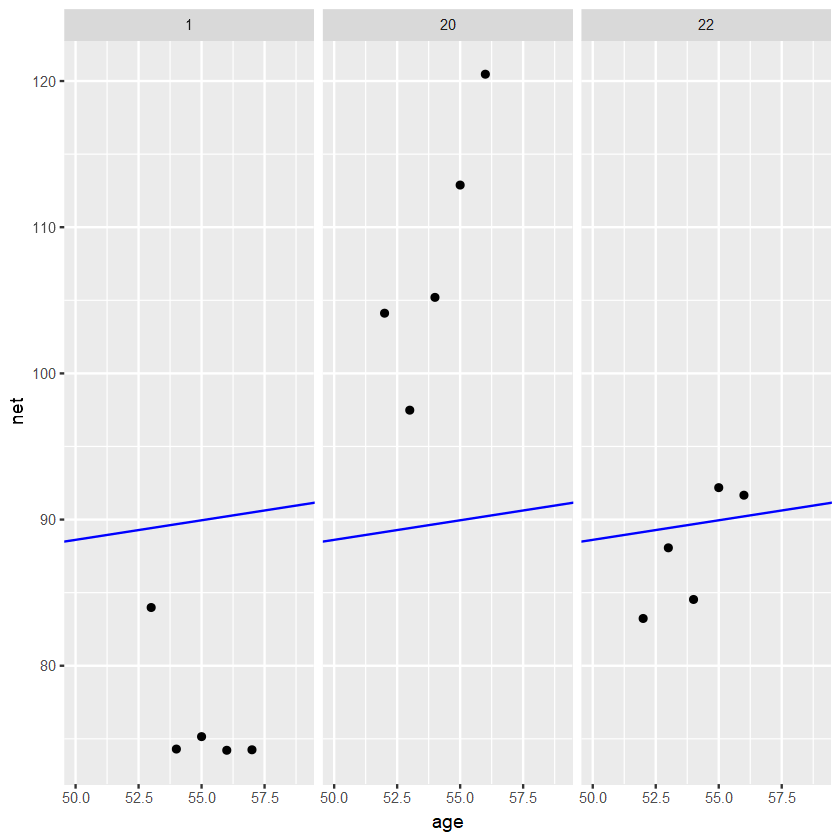

In [13]:
examples <- running %>% 
  filter(runner %in% c("1", "20", "22"))

ggplot(examples, aes(x = age, y = net)) + 
  geom_point() + 
  facet_wrap(~ runner) + 
  geom_abline(aes(intercept = 75.2242, slope = 0.2678), 
              color = "blue")



<br>

#### 위의 그룹화된 데이터에 대한 완전풀링 분석은, 완전풀링의 가정을 위배하고 있음
1. 한 명의 기록에 대한 관측값은 다른 사람의 기록과 독립적일 수 있지만, 한 명의 기록들 안에서의 관측값들은 서로 연관되어 있음
    
    즉, 주자의 전년도 기록이 다음 기록에 영향을 줄 수 잇음
    
<br>
    
2. 변수들간의 관계는 일반화 될 수 없음

    즉, 주자마다 다름




<br>

### 그룹화된 데이터에 대한 완전풀링 분석의 단점
1. 관측값 별 독립성 가정을 위배
2. 설명변수별 관계에 잘못된 설명으로 이어짐

<br>

## 15.02. 개별풀링
#### 관측값들의 특정 단위(범주)에 따른 관측값들을, 가능한 많은 풀로 구분하여
#### 각각의 풀 별 모형을 구축

<br>

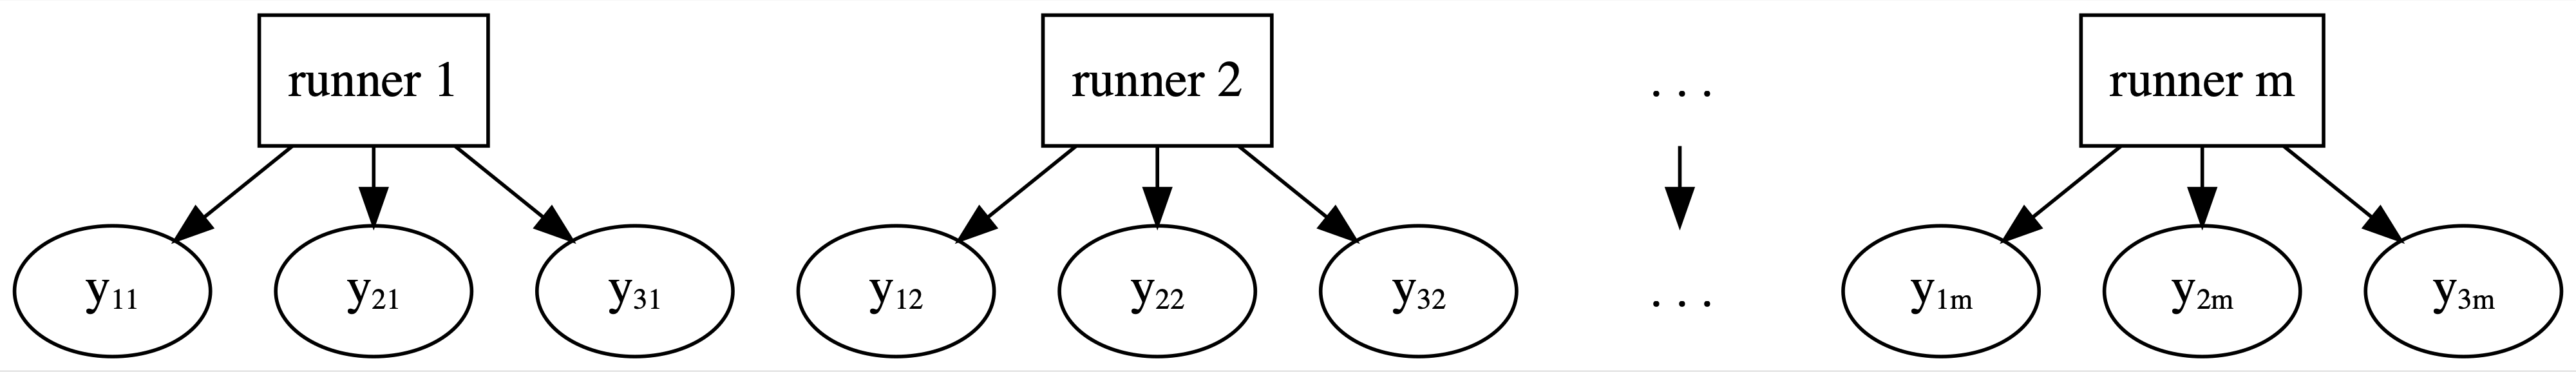

<br>

#### 각 사람마다의 별도 모형을 구축

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 6 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_point()`)."


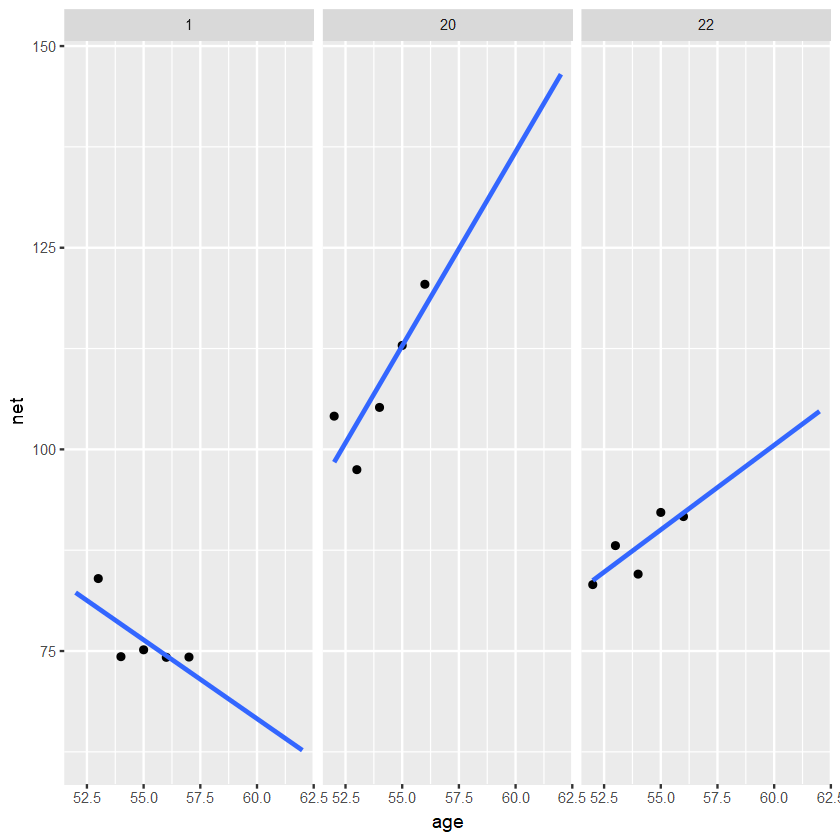

In [14]:
ggplot(examples, aes(x = age, y = net)) + 
  geom_point() + 
  geom_smooth(method = "lm", se = FALSE, fullrange = TRUE) + 
  facet_wrap(~ runner) + 
  xlim(52, 62)

<br>

### 그룹화된 데이터에 대한 개별풀링 분석의 단점
1. 관측값들을 일반화하여 설명할 수 없음
2. 각 풀별 모형은 다른 풀의 관측값들에 대해서 설명할 수 없음

<br>

## 15.03. 계층적 데이터 (그룹화된 데이터)
### 계층적 데이터의 장점
1. 그룹간 변동성에 대해 분석 가능
2. 그룹내 변동성에 대해 분석 가능

<br>

## 15.04. 일부풀링
#### 각 개별 그룹이 고유한 모형을 갖고 있지만, 각 그룹별 모형이 다른 그룹에 대한 정보를 제공할 수 있다는 점이 고려한, 개별풀링과 완전풀링의 절충안

<br>

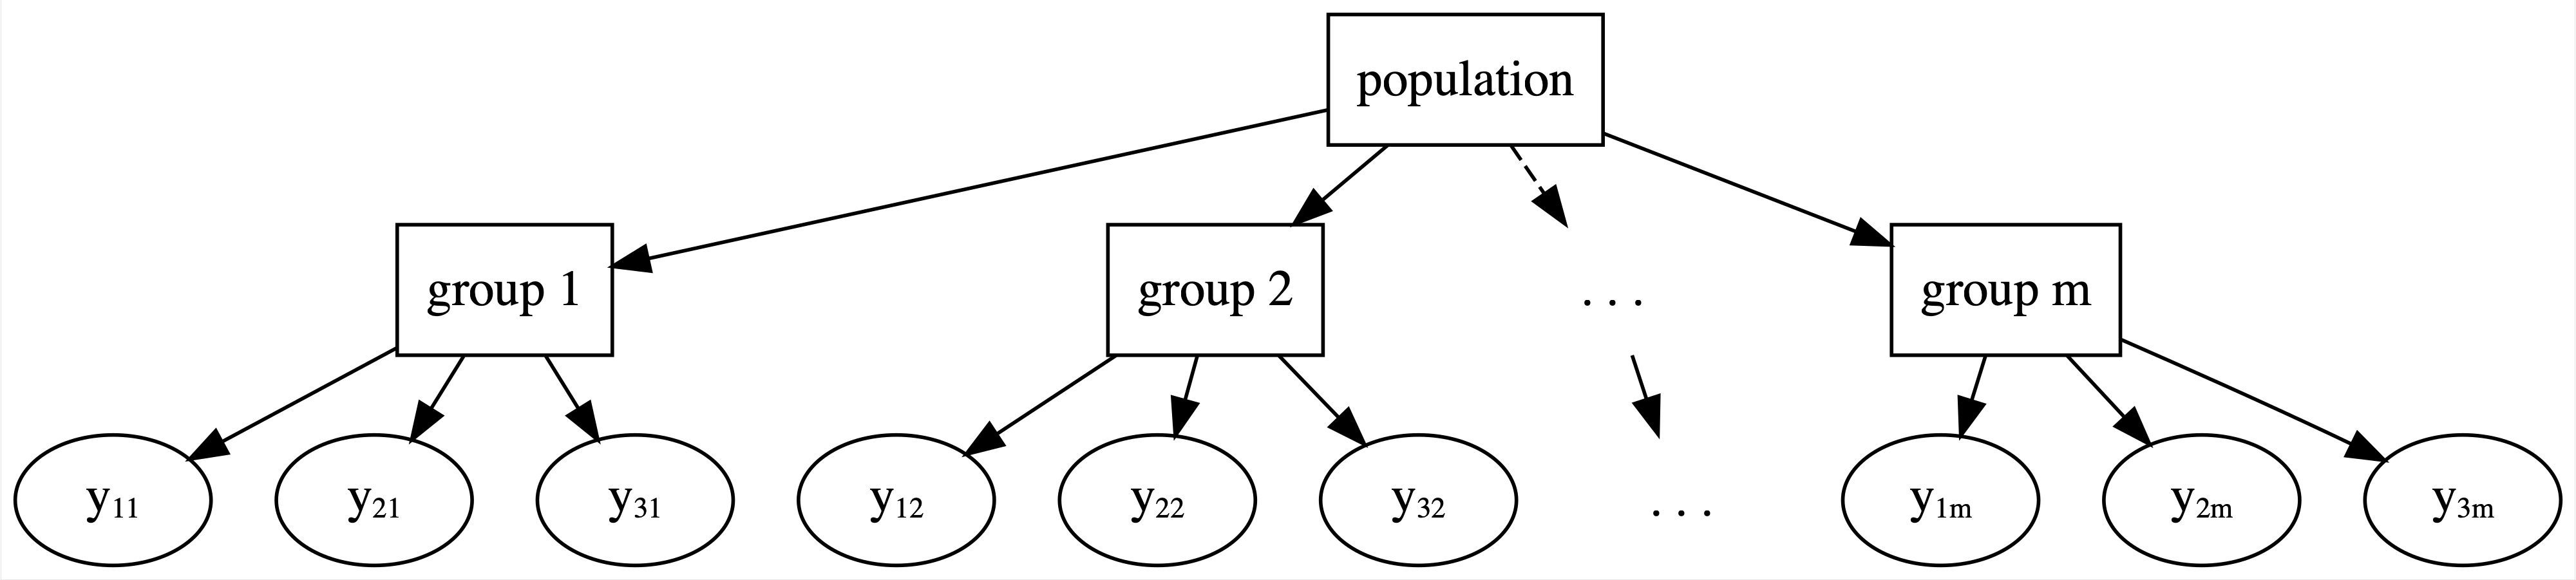